In [2]:
import Orange
import numpy as np
import pandas as pd

In [7]:
from Orange.data import Table
def sample_data(data, samples_per_class = 20):
    for i, value in enumerate(np.unique(data.Y)):
        indices, = np.where(data.Y == value)
        data_per_class = data[indices]
        sampled_data_class = data_per_class[np.random.choice(len(data_per_class), size=samples_per_class, replace=False)]
        if i == 0:
            sampled_data = sampled_data_class
        else:
            sampled_data = Table.concatenate((sampled_data, sampled_data_class))
    return sampled_data

In [8]:
from Orange.data import Table, Domain, ContinuousVariable, DiscreteVariable
def load_data(number_features = 1, error = 1):
    world = pd.read_csv(f'../data/{number_features}_feature/{number_features}feat_0seed_{error}err_obs-unc-tru.csv')
    X = np.column_stack([world[f"Observed Value {i+1}"] for i in range(number_features)])
    Y = np.array(world["Class"])
    M = np.column_stack([world[f"Uncertainty {i+1}"] for i in range(number_features)])
    Xtv = np.column_stack([world[f"True Value {i+1}"] for i in range(number_features)])
    
    domain = Domain(
        attributes = [ContinuousVariable(f"Observed Value {i+1}") for i in range(number_features)],
        class_vars = DiscreteVariable("Class", values=[str(i) for i in range(max(Y+1))]),
        metas = [ContinuousVariable(f"Uncertainty {i+1}") for i in range(number_features)]
    )
    data = Table.from_numpy(domain, X=X, Y=Y, metas=M)
    
    domain = Domain(
        attributes = [ContinuousVariable(f"Observed Value {i+1}") for i in range(number_features)],
        class_vars = DiscreteVariable("Class", values=[str(i) for i in range(max(Y+1))])
    )
    # X = tv1.reshape(-1, 1)
    test_data = Table.from_numpy(domain, X=Xtv, Y=Y)
    return data, test_data
    

In [9]:
data, test_data = load_data(3)
data

[[-0.420057, 0.58984, -1.39719 | 0] {0.0311298, 0.87465, 0.999956},
 [-0.81707, 0.163862, -0.272897 | 0] {0.361953, 0.740208, 0.0812085},
 [-1.46467, 0.821579, -0.838727 | 0] {0.902254, 0.929806, 0.80239},
 [-0.965303, -0.304932, -0.385335 | 0] {0.348744, 0.0966572, 0.0857702},
 [-0.440521, 0.485449, -1.19095 | 0] {0.00856598, 0.559853, 0.261984},
 ...
]

In [10]:
test_data

[[-0.451186, -0.284811, -0.397237 | 0],
 [-0.455117, -0.576345, -0.354106 | 0],
 [-0.562413, -0.108227, -0.0363372 | 0],
 [-0.616558, -0.208275, -0.471105 | 0],
 [-0.431955, -0.0744034, -0.928964 | 0],
 ...
]

In [11]:
from trees.util.uncertaintreelearner import UncertainTreeLearner
from trees.util.uncertainforestutil import UncertainForestLearner
from trees.owtree import ClassificationTreeLearner
from Orange.modelling.constant import ConstantLearner

In [12]:
post_hoc = UncertainTreeLearner(max_depth=None, min_samples_leaf=2, min_samples_split=4, sufficient_majority=0.90, post_hoc=True)
forward = UncertainTreeLearner(max_depth=None, min_samples_leaf=2, min_samples_split=4, sufficient_majority=0.90, post_hoc=False)
skl_tree = ClassificationTreeLearner(max_depth=None, min_samples_leaf=2, min_samples_split=4, sufficient_majority=0.90)
uncertain_forest10 = UncertainForestLearner(n_trees=10)
mojority = ConstantLearner()

In [13]:
from Orange.evaluation import TestOnTestData
from Orange.evaluation.scoring import CA
rep = 33
for i in range(3):
    i += 1
    for err in [0.1, 0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6]:
        data, test_data = load_data(i, error=err)
        average_CA = np.array([0, 0, 0, 0, 0], dtype="float64")
        for _ in range(rep):
            res = TestOnTestData(data=sample_data(data, 20), test_data=test_data, learners=[skl_tree, forward, post_hoc, uncertain_forest10, mojority])
            average_CA += CA(res)
        print(f"""{i} Feature, Error {err}
skl_tree  {round(average_CA[0]/rep, 3)}
forward   {round(average_CA[1]/rep, 3)} *min number of instances in leaf no work
post_hoc  {round(average_CA[2]/rep, 3)}
forest10  {round(average_CA[3]/rep, 3)}
mojority  {round(average_CA[4]/rep, 3)}""")    
    print("-----------")

1 Feature, Error 0.1
skl_tree  0.974
forward   0.975 *min number of instances in leaf no work
post_hoc  0.975
forest10  0.972
mojority  0.5
1 Feature, Error 0.2
skl_tree  0.968
forward   0.97 *min number of instances in leaf no work
post_hoc  0.968
forest10  0.965
mojority  0.5
1 Feature, Error 0.4
skl_tree  0.934
forward   0.937 *min number of instances in leaf no work
post_hoc  0.944
forest10  0.945
mojority  0.5
1 Feature, Error 0.6
skl_tree  0.86
forward   0.911 *min number of instances in leaf no work
post_hoc  0.92
forest10  0.92
mojority  0.5
1 Feature, Error 0.8
skl_tree  0.792
forward   0.897 *min number of instances in leaf no work
post_hoc  0.891
forest10  0.92
mojority  0.5
1 Feature, Error 1
skl_tree  0.698
forward   0.874 *min number of instances in leaf no work
post_hoc  0.898
forest10  0.928
mojority  0.5
1 Feature, Error 1.2
skl_tree  0.667
forward   0.842 *min number of instances in leaf no work
post_hoc  0.902
forest10  0.921
mojority  0.5
1 Feature, Error 1.4
skl_tr

KeyboardInterrupt: 

In [2]:
from ipywidgets import IntProgress
from IPython.display import display
import time
from IPython.core.display import HTML

# Custom CSS to change the background color of the progress bar
display(HTML("""
    <style>
        .progress .progress-bar {
            background-color: #f60 !important; /* Change the progress bar background color to black */
        }
    </style>
"""))

for i in range(3):
    print(i)
    max_count = 100

    f = IntProgress(min=0, max=max_count)  # instantiate the bar
    display(f)  # display the bar

    count = 0
    while count <= max_count:
        f.value += 1  # signal to increment the progress bar
        time.sleep(0.1)
        count += 1

0


IntProgress(value=0)

1


IntProgress(value=0)

2


IntProgress(value=0)

In [5]:
from tqdm.notebook import tqdm
a = tqdm(total=10, desc="Feature")
b = tqdm(total=10, desc="Feature")
for i in range(10):
    b.reset()
    for i in range(10):
        time.sleep(.01)
        b.update()
    a.update()

Feature:   0%|          | 0/10 [00:00<?, ?it/s]

Feature:   0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
import multiprocessing

def worker(procnum, return_dict):
    """worker function"""
    print(str(procnum) + " represent!")
    return_dict[procnum] = procnum


if __name__ == "__main__":
    manager = multiprocessing.Manager()
    return_dict = manager.dict()
    jobs = []
    for i in range(5):
        p = multiprocessing.Process(target=worker, args=(i, return_dict))
        jobs.append(p)
        p.start()

    for proc in jobs:
        proc.join()
    print(return_dict.values())

0 represent!
1 represent!
2 represent!
3 represent!
4 represent!
[0, 1, 2, 3, 4]


In [ ]:
from multiprocessing import Pool

data = [('bla', 1, 3, 7), ('spam', 12, 4, 8), ('eggs', 17, 1, 3)]

def f(t):
    name, a, b, c = t
    return (name, a + b + c)

p = Pool()
results = p.map(f, data)
results

[('bla', 11), ('spam', 24), ('eggs', 21)]

In [1]:
from utils import *
import numpy as np

tv = np.random.rand(10**7)

In [10]:
arr = []
for t in tv:
    continue
    arr.append(add_unc(t, corr = 0.7))
np.array(arr)

array([], dtype=float64)

In [28]:
arr = add_unc(tv, corr = 0.9)
tv_ov_unc = np.c_[tv, arr]
err = tv_ov_unc[:, 1] - tv_ov_unc[:, 0]
unc = tv_ov_unc[:, 2]
np.corrcoef(unc, np.abs(err))[0,1]

0.8940062499923078

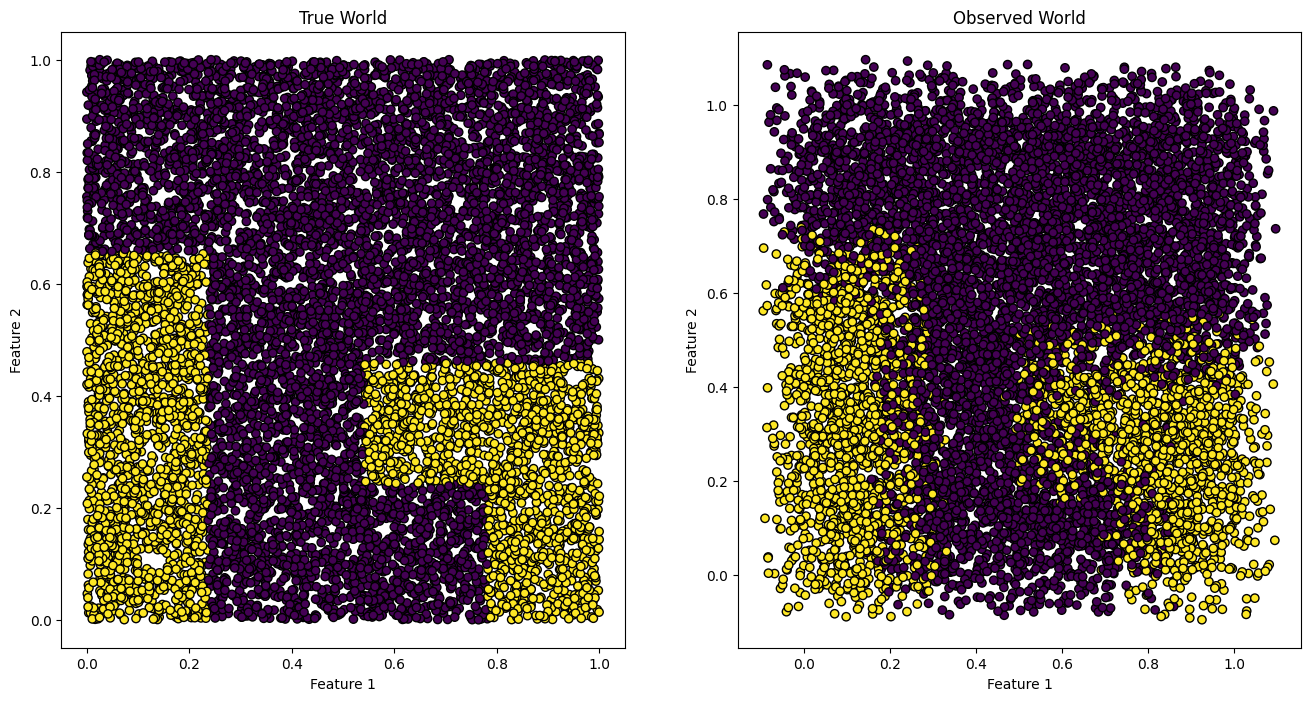

In [15]:
from ploting import *
draw_combined_world(generate_world(1, 2, feature_bounds=(0, 1), corr=0.6))

In [474]:
from random import uniform, randint, gauss
X = []
corr = []
tvValues = [0, 1]
error = 1
tv = np.random.rand(10**5) * (tvValues[1] - tvValues[0]) + tvValues[0]
for x in np.linspace(0, 2, 300):
    rv = np.array([t + error * gauss(0, x) for t in tv])
    cor = np.corrcoef(tv, rv)[0,1]
    print(f"X = {x:^5}, corr = {cor}")
    X.append(x)
    corr.append(cor)

X =  0.0 , corr = 1.0
X = 0.006688963210702341, corr = 0.9997305848201873
X = 0.013377926421404682, corr = 0.9989260853361445
X = 0.020066889632107024, corr = 0.9975912650102999
X = 0.026755852842809364, corr = 0.9957137190311453
X = 0.033444816053511704, corr = 0.9932922921768961
X = 0.04013377926421405, corr = 0.990477467738791
X = 0.046822742474916385, corr = 0.987044169875652
X = 0.05351170568561873, corr = 0.9832518645871596
X = 0.06020066889632107, corr = 0.9789072516773173
X = 0.06688963210702341, corr = 0.9740096368859954
X = 0.07357859531772575, corr = 0.9687697785220097
X = 0.0802675585284281, corr = 0.9631383604287325
X = 0.08695652173913043, corr = 0.9574131889773497
X = 0.09364548494983277, corr = 0.9508964339684041
X = 0.10033444816053512, corr = 0.9442813225208443
X = 0.10702341137123746, corr = 0.9371344095035196
X = 0.11371237458193979, corr = 0.9299158479736614
X = 0.12040133779264214, corr = 0.922440238545757
X = 0.12709030100334448, corr = 0.9147909955613841
X = 0.1

array([[[-0.55193385,  0.09289829],
        [-0.94298438, -1.07419239],
        [ 1.11163337,  1.71945652],
        ...,
        [-2.27565039, -2.14329299],
        [ 0.84112657,  0.66323916],
        [-0.81624627, -1.05973166]],

       [[-0.39724886,  0.36249625],
        [ 2.24809273,  3.39072872],
        [-1.04191883, -1.0008673 ],
        ...,
        [-1.62263613, -1.09260816],
        [ 0.14435997, -0.14269557],
        [ 0.65939184,  0.12886969]]])

corr = 0.8689909472799112


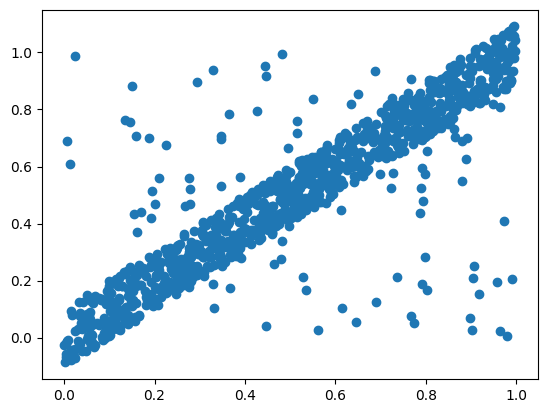

In [660]:
import matplotlib.pyplot as plt
import random

tvValues = [0, 1]
error = 0.1
tv = np.random.rand(10**3) * (tvValues[1] - tvValues[0]) + tvValues[0]

rv = np.array([random.random() if random.random() < 0.1 else t + error * random.uniform(-1, 1) for t in tv])
# rv = tv + rvError

plt.scatter(tv, rv)
cor = np.corrcoef(tv, rv)[0,1]
print(f"corr = {cor}")

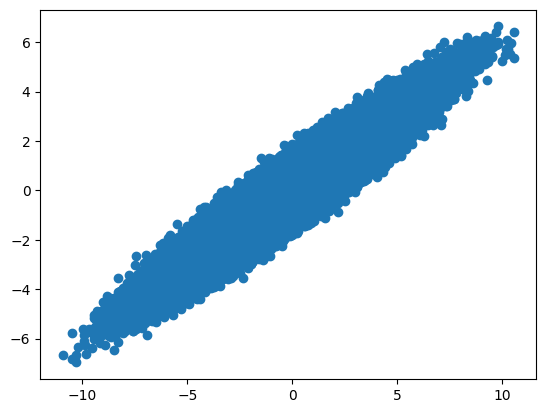

In [161]:
mean = (0, 0)
cov = np.array(
    [[5, 3],
     [3, 2]
    ])
data = np.random.multivariate_normal(mean, cov, size=(10**6))
plt.scatter(data[:, 0] , data[:, 1])

In [487]:
np.polyfit(corr, X, 10)

array([-1.01929899e+04,  5.74033018e+04, -1.40806769e+05,  1.97296420e+05,
       -1.73976298e+05,  1.00182085e+05, -3.77562070e+04,  9.02568027e+03,
       -1.25248589e+03,  7.58426902e+01,  1.42784898e+00])

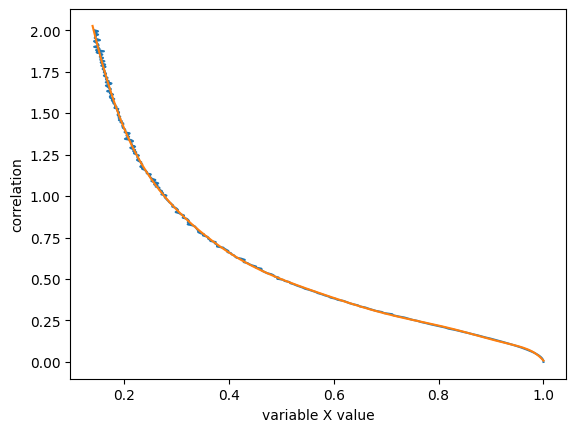

In [486]:

p = np.poly1d(np.polyfit(corr, X, 10))
# p_all = np.linalg.lstsq(corr, X)

# plt.plot(X, corr)
plt.plot(corr, X)
plt.ylabel("correlation")
plt.xlabel("variable X value")

linspace = np.linspace(.14, 1, 200)
# plt.plot(corr, X)
Y = list(map(p, linspace))
plt.plot(linspace, Y)
# plt.plot(Y, X)

plt.show()

In [ ]:
p = np.poly1d(np.array([-1.01929899e+04,  5.74033018e+04, -1.40806769e+05,  1.97296420e+05,
       -1.73976298e+05,  1.00182085e+05, -3.77562070e+04,  9.02568027e+03,
       -1.25248589e+03,  7.58426902e+01,  1.42784898e+00]))

0.8892442257946004


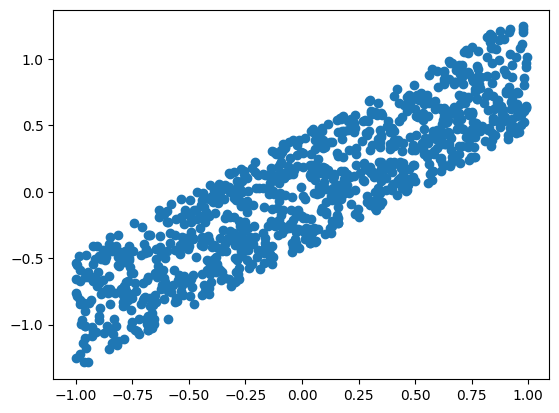

In [651]:
tvValues = [-1, 1]
n = 10**3
r = 0.9
x1 = np.random.rand(n) * (tvValues[1] - tvValues[0]) + tvValues[0]
x2 = np.random.rand(n) * (tvValues[1] - tvValues[0]) + tvValues[0]
y1 = r*x2+np.sqrt(1-r*r)*x1 
print(np.corrcoef(y1, x2)[0, 1])
plt.scatter(x2, y1)